<a href="https://colab.research.google.com/github/amitchug/ALMlops/blob/main/M3_SNB_MiniProject_1_ResumeClassification_Using_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Programme in AI and MLOps
## A programme by IISc and TalentSprint
### Mini-Project 1: Resume Classification

**DISCLAIMER:** THIS NOTEBOOK IS PROVIDED ONLY AS A REFERENCE SOLUTION NOTEBOOK FOR THE MINI-PROJECT. THERE MAY BE OTHER POSSIBLE APPROACHES/METHODS TO ACHIEVE THE SAME RESULTS.

## Learning Objectives

At the end of the mini-project, you will be able to :

* perform data preprocessing, EDA on the resume dataset
* fine-tune Bert model for resume classification

## Dataset Description

The data is in CSV format, with two features: Category, and Resume.

**Category** -  Industry sector to which the resume belongs to, and

**Resume** - The complete CV (text) of the candidate.

##  Grading = 10 Points

## Information

Companies often receive thousands of resumes for each job posting and employ dedicated screening officers to screen qualified candidates. Finding suitable candidates for an open role from a database of 1000s of resumes can be a tough task. Automated resume categorization can speeden the candidate selection process. Such automation can really ease the tedious process of fair screening and shortlisting the right candidates and aid quick decisionmaking.

To learn more about this, click [here](https://www.sciencedirect.com/science/article/pii/S187705092030750X).

**Problem Statement:** Fine-tune a pre-trained Bert model for resume classification.

*For fine-tuning Bert, refer to the HuggingFace platform session held on 17 Aug.*

### Install dependencies

After installing the below dependencies ***Restart the session/runtime***.

In [ ]:
!pip -q uninstall pyarrow -y
!pip -q install pyarrow==15.0.2
!pip -q install datasets
!pip -q install accelerate
!pip -q install transformers

# Ignore the Error/Warning showing after running this cell

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


### <font color="#990000">Restart Session/Runtime</font>

### Import required packages

In [ ]:
from datasets import Dataset, DatasetDict

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
from transformers import pipeline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Downloading the data

In [ ]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/Datasets/UpdatedResumeDataSet.csv
!ls | grep '.csv'

UpdatedResumeDataSet.csv


**Exercise 1: Read the UpdatedResumeDataset.csv dataset [0.5 Mark]**

**Hint:** pd.read_csv( , encoding='utf-8')

In [ ]:
df = pd.read_csv('UpdatedResumeDataSet.csv', encoding='utf-8')
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


### Pre-processing and EDA

**Exercise 2: Display  all the categories of resumes and their counts in the dataset [0.5 Mark]**



In [ ]:
# Displaying the distinct categories of resume
print(df['Category'].unique())

['Data Science' 'HR' 'Advocate' 'Arts' 'Web Designing'
 'Mechanical Engineer' 'Sales' 'Health and fitness' 'Civil Engineer'
 'Java Developer' 'Business Analyst' 'SAP Developer' 'Automation Testing'
 'Electrical Engineering' 'Operations Manager' 'Python Developer'
 'DevOps Engineer' 'Network Security Engineer' 'PMO' 'Database' 'Hadoop'
 'ETL Developer' 'DotNet Developer' 'Blockchain' 'Testing']


In [ ]:
# Displaying the number of distinct categories of resume
print(df['Category'].nunique())

25


In [ ]:
# Displaying the distinct categories of resume and the number of records belonging to each category
print(df['Category'].value_counts())

Category
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Sales                        40
Data Science                 40
Mechanical Engineer          40
ETL Developer                40
Blockchain                   40
Operations Manager           40
Arts                         36
Database                     33
Health and fitness           30
PMO                          30
Electrical Engineering       30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
Civil Engineer               24
SAP Developer                24
Advocate                     20
Name: count, dtype: int64


**Exercise 3: Create the count plot of different categories [0.5 Mark]**

**Hint:** Use `sns.countplot()`

<Axes: xlabel='count', ylabel='Category'>

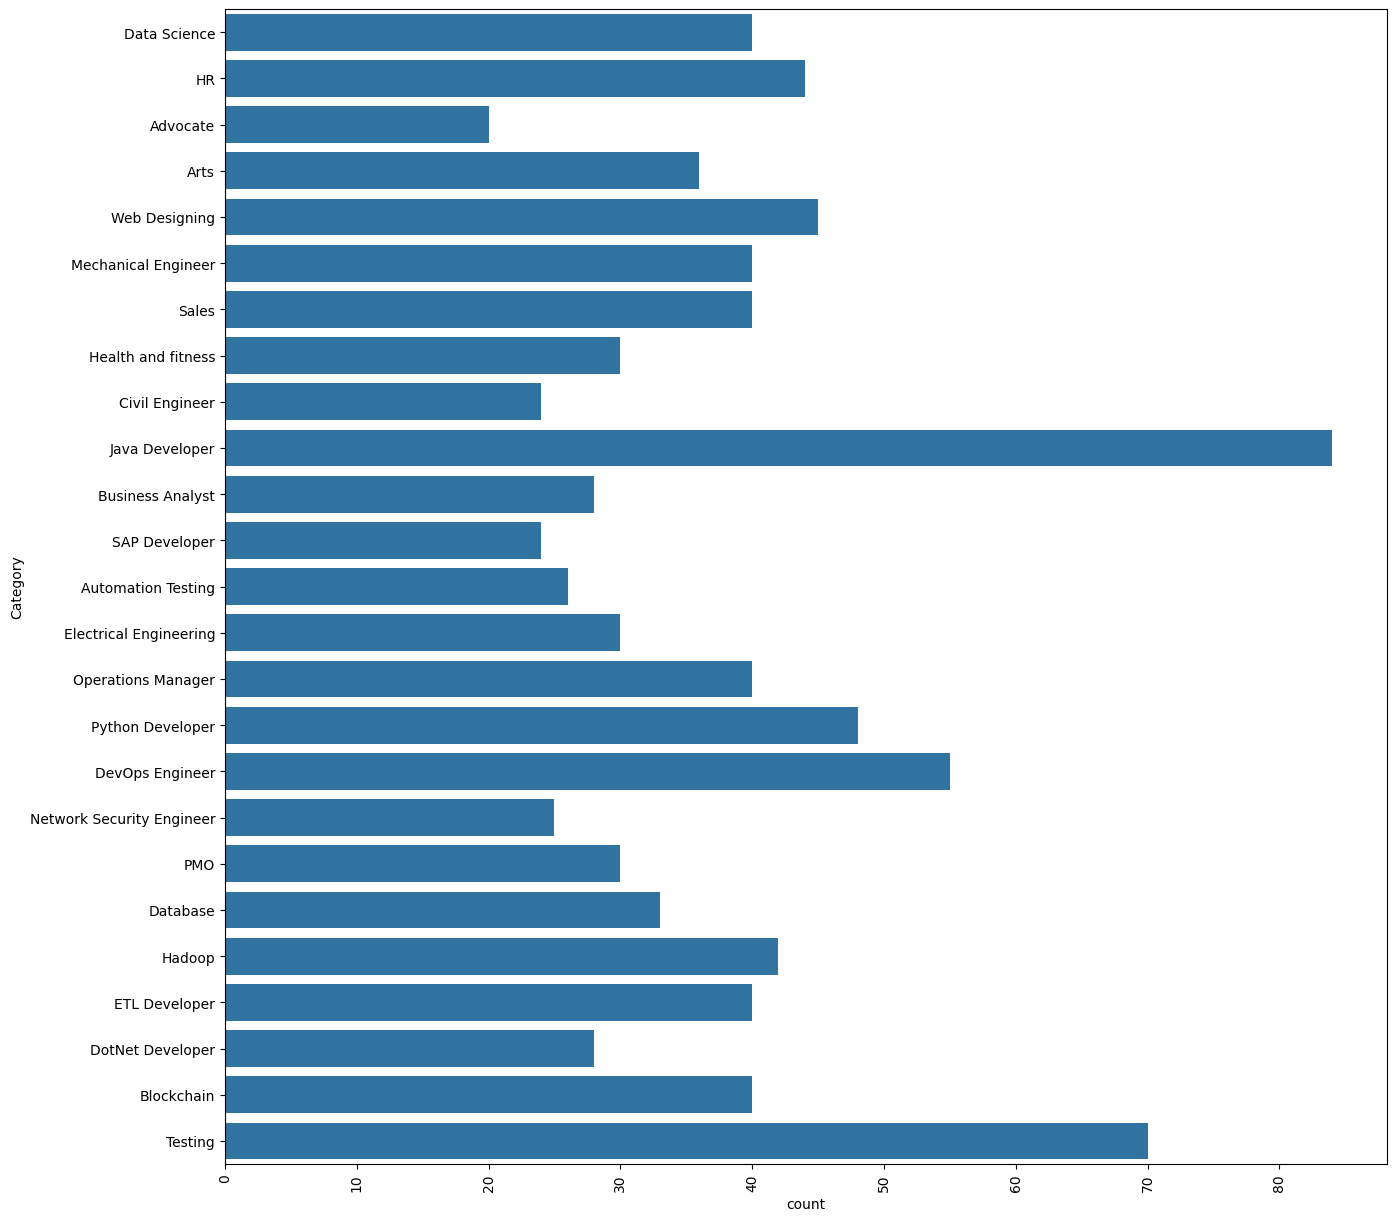

In [ ]:
plt.figure(figsize=(15,15))
plt.xticks(rotation=90)
sns.countplot(y="Category", data=df)

**Exercise 4: Create a pie plot depicting the percentage of resume distributions category-wise. [0.5 mark]**

**Hint:** Use [plt.pie()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pie.html) and [plt.get_cmap](https://matplotlib.org/stable/tutorials/colors/colormaps.html) for color mapping the pie chart.

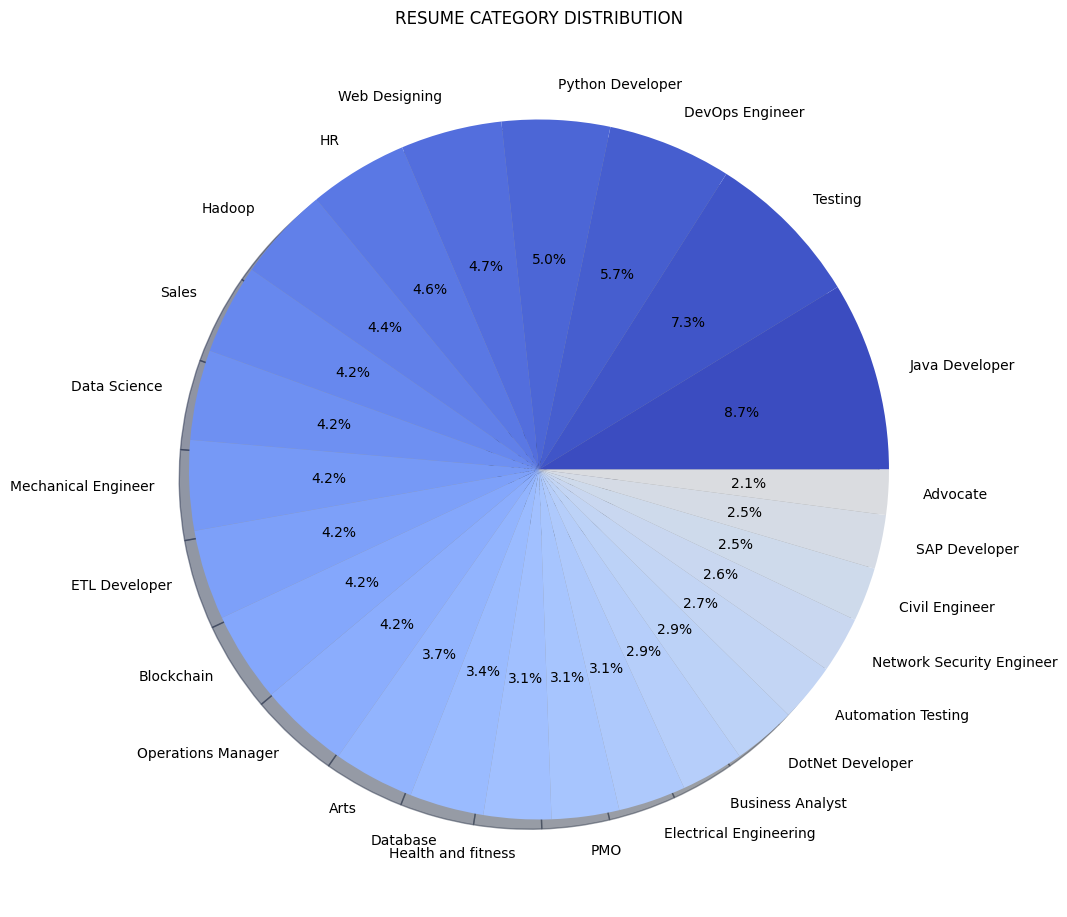

In [ ]:
targetCounts = df['Category'].value_counts()
targetLabels  = targetCounts.index
# Make square figures and axes
plt.figure(1, figsize=(25,25))
the_grid = GridSpec(2, 2)


cmap = plt.get_cmap('coolwarm')
colors = [cmap(i) for i in np.linspace(0, 1)]
plt.subplot(the_grid[0, 1], aspect=1, title='RESUME CATEGORY DISTRIBUTION')

source_pie = plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', shadow=True, colors=colors)
plt.show()

**Exercise 5: Convert all the `Resume` text to lower case and remove trailing spaces [0.5 Mark]**




In [ ]:
# Convert all characters to lowercase and remove trailing spaces
df['Resume'] = df['Resume'].str.lower()
df['Resume'] = df['Resume'].str.strip()
print(df['Resume'])

0      skills * programming languages: python (pandas...
1      education details \r\nmay 2013 to may 2017 b.e...
2      areas of interest deep learning, control syste...
3      skills â¢ r â¢ python â¢ sap hana â¢ table...
4      education details \r\n mca   ymcaust,  faridab...
                             ...                        
957    computer skills: â¢ proficient in ms office (...
958    â willingness to accept the challenges. â ...
959    personal skills â¢ quick learner, â¢ eagerne...
960    computer skills & software knowledge ms-power ...
961    skill set os windows xp/7/8/8.1/10 database my...
Name: Resume, Length: 962, dtype: object


### Cleaning Resume

**Exercise 6: Define a function to clean the resume text [2 Mark]**

In the text there are special characters, urls, hashtags, mentions, etc. You need to remove for the following:  

* URLs: For reference click [here](https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python)
* RT | cc: For reference click [here](https://www.machinelearningplus.com/python/python-regex-tutorial-examples/)
* Hashtags, # and Mentions, @
* punctuations
* extra whitespace

PS: Use the provided reference similarly for removing any other such elements.

After cleaning as above, store the Resume Text in a separate column (New Feature say `Cleaned_Resume`).


In [ ]:
import re

def cleanResume(resumeText):
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)       # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)         # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)       # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)    # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText)
    resumeText = re.sub('\s+', ' ', resumeText)         # remove extra whitespace
    return resumeText


In [ ]:
df['Cleaned_Resume'] = df['Resume'].apply(lambda x: cleanResume(x))
print(df['Cleaned_Resume'][31])

education details may 2013 to may 2017 b e uit rgpv data scientist data scientist matelabs skill details python exprience less than 1 year months statsmodels exprience 12 months aws exprience less than 1 year months machine learning exprience less than 1 year months sklearn exprience less than 1 year months scipy exprience less than 1 year months keras exprience less than 1 year monthscompany details company matelabs description ml platform for business professionals dummies and enthusiasts 60 a koramangala 5th block achievements tasks behind sukh sagar bengaluru india developed and deployed auto preprocessing steps of machine learning mainly missing value treatment outlier detection encoding scaling feature selection and dimensionality reduction deployed automated classification and regression model linkedin com in aditya rathore b4600b146 reasearch and deployed the time series forecasting model arima sarimax holt winter and prophet worked on meta feature extracting problem github com

In [ ]:
df.head()    # data after cleaning the resume

,Category,Resume,Cleaned_Resume
0,Data Science,skills * programming languages: python (pandas...,skills programming languages python pandas num...
1,Data Science,education details \r\nmay 2013 to may 2017 b.e...,education details may 2013 to may 2017 b e uit...
2,Data Science,"areas of interest deep learning, control syste...",areas of interest deep learning control system...
3,Data Science,skills â¢ r â¢ python â¢ sap hana â¢ table...,skills r python sap hana tableau sap hana sql ...
4,Data Science,"education details \r\n mca ymcaust, faridab...",education details mca ymcaust faridabad haryan...


In [ ]:
df["Resume"][100] ,  df["Cleaned_Resume"][100]

('skills: natural languages: proficient in english, hindi and marathi. computer skills: proficient with ms-office, internet operation.education details \r\njanuary 2015 to january 2018 llb law mumbai, maharashtra mumbai university\r\njanuary 2015 b.m.m  mumbai, maharashtra s.k.somaiya college, mumbai university\r\n h.s.c   asmita girls junior college, maharashtra board\r\n s.s.c vidya bhawan  maharashtra board\r\nadvocate \r\n\r\nllb student and journalist\r\nskill details \r\ncompany details \r\ncompany - criminal lawyer (law firm)\r\ndescription -',
 'skills natural languages proficient in english hindi and marathi computer skills proficient with ms office internet operation education details january 2015 to january 2018 llb law mumbai maharashtra mumbai university january 2015 b m m mumbai maharashtra s k somaiya college mumbai university h s c asmita girls junior college maharashtra board s s c vidya bhawan maharashtra board advocate llb student and journalist skill details company

**Exercise 7: Convert the categorical variable `Category` to a numerical feature and make a different column <font color="#990000">`label`</font>, which can be treated as the target variable [0.5 Mark]**

**Hint:** Use [`sklearn.preprocessing.LabelEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) method

In [ ]:
labelencoder = LabelEncoder()
df["label"] = labelencoder.fit_transform(df["Category"])

df.head()

,Category,Resume,Cleaned_Resume,label
0,Data Science,skills * programming languages: python (pandas...,skills programming languages python pandas num...,6
1,Data Science,education details \r\nmay 2013 to may 2017 b.e...,education details may 2013 to may 2017 b e uit...,6
2,Data Science,"areas of interest deep learning, control syste...",areas of interest deep learning control system...,6
3,Data Science,skills â¢ r â¢ python â¢ sap hana â¢ table...,skills r python sap hana tableau sap hana sql ...,6
4,Data Science,"education details \r\n mca ymcaust, faridab...",education details mca ymcaust faridabad haryan...,6


**Exercise 8: Plot the histogram of words count of `Cleaned_Resume` text [0.5 Mark]**

**Hint:** Use sns.distplot()

In [ ]:
df['Count'] = df['Cleaned_Resume'].apply(lambda x: len(x.split()))

<Figure size 800x800 with 0 Axes>

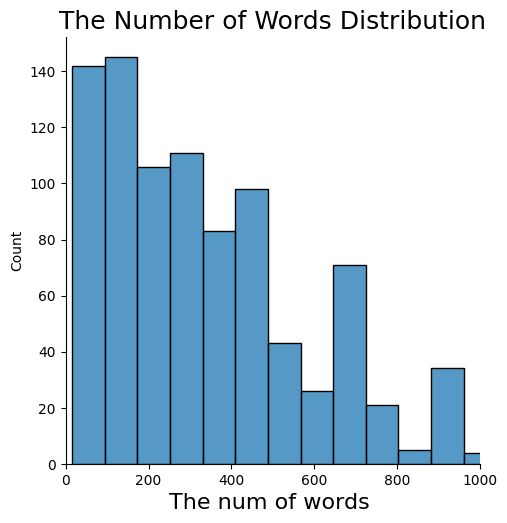

In [ ]:
plt.figure(figsize= (8, 8))

sns.displot(df['Count'])

plt.xlim(0, 1000)
plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

In [ ]:
df.head(2)

,Category,Resume,Cleaned_Resume,label,Count
0,Data Science,skills * programming languages: python (pandas...,skills programming languages python pandas num...,6,653
1,Data Science,education details \r\nmay 2013 to may 2017 b.e...,education details may 2013 to may 2017 b e uit...,6,163


### Train Test Split

**Exercise 9: Split the dataset into training, validation, and testing set [0.5 Mark]**

* Do stratified splitting using `label` column

In [ ]:
train_test_df, val_df = train_test_split(df, test_size = 0.2, random_state = 42, stratify = df['label'])
train_df, test_df = train_test_split(train_test_df, test_size = 25, random_state = 42, stratify = train_test_df['label'])

len(train_df), len(val_df), len(test_df)

(744, 193, 25)

In [ ]:
train_df.head(2)

,Category,Resume,Cleaned_Resume,label,Count
341,Java Developer,"operating systems windows xp, 7, 10. tools/pac...",operating systems windows xp 7 10 tools packag...,15,260
70,HR,training in special education (certificate cou...,training in special education certificate cour...,12,81


### Convert to HuggingFace Dataset

**Exercise 10: Convert Pandas dataframe to HuggingFace Dataset [1 Mark]**

**Hint:**

    import pandas as pd
    from datasets import Dataset, DatasetDict

    tdf = pd.DataFrame({"a": [1, 2, 3], "b": ['hello', 'ola', 'thammi']})
    vdf = pd.DataFrame({"a": [4, 5, 6], "b": ['four', 'five', 'six']})
    tds = Dataset.from_pandas(tdf)
    vds = Dataset.from_pandas(vdf)

    ds = DatasetDict()

    ds['train'] = tds
    ds['validation'] = vds

    print(ds)

In [ ]:
from datasets import Dataset, DatasetDict

train_ds = Dataset.from_pandas(train_df[['Cleaned_Resume', 'label']])
val_ds = Dataset.from_pandas(val_df[['Cleaned_Resume', 'label']])
test_ds = Dataset.from_pandas(test_df[['Cleaned_Resume', 'label']])

ds = DatasetDict()

ds['train'] = train_ds
ds['validation'] = val_ds
ds['test'] = test_ds

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['Cleaned_Resume', 'label', '__index_level_0__'],
        num_rows: 744
    })
    validation: Dataset({
        features: ['Cleaned_Resume', 'label', '__index_level_0__'],
        num_rows: 193
    })
    test: Dataset({
        features: ['Cleaned_Resume', 'label', '__index_level_0__'],
        num_rows: 25
    })
})

In [ ]:
ds['train']

Dataset({
    features: ['Cleaned_Resume', 'label', '__index_level_0__'],
    num_rows: 744
})

In [ ]:
ds['train'].features

{'Cleaned_Resume': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

### Tokenizer

**Exercise 11: Load tokenizer for checkpoint `distilbert-base-uncased` [0.5 Mark]**

**Hint:** `AutoTokenizer`

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# tokenized_sentence = tokenizer(ds['train'][0:2]['Cleaned_Resume'], truncation = True, padding = True)

# from pprint import pprint
# pprint(tokenized_sentence)

In [ ]:
def tokenize_fn(batch):
    return tokenizer(batch['Cleaned_Resume'], truncation=True, padding = True)

In [ ]:
tokenized_datasets = ds.map(tokenize_fn, batched=True)

Map:   0%|          | 0/744 [00:00<?, ? examples/s]

Map:   0%|          | 0/193 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['Cleaned_Resume', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 744
    })
    validation: Dataset({
        features: ['Cleaned_Resume', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 193
    })
    test: Dataset({
        features: ['Cleaned_Resume', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 25
    })
})

### Load Pre-Trained Model

**Exercise 12: Load pre-trained Bert model with checkpoint `distilbert-base-uncased` and show model summary [0.5 Mark]**

**Hint:** `AutoModelForSequenceClassification`

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=25)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
type(model)

transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification

In [ ]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
!pip -q install torchinfo

In [ ]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           19,225
├─Dropout: 1-4                                          --
Total params: 66,972,697
Trainable params: 66,972,697
Non-trainable params: 0

**Exercise 13: Freeze/Un-Freeze different layers  [0.5 Mark]**

**Hint:** Freeze layers starting with name *distilbert*


In [ ]:
for name, param in model.named_parameters():
    print(name)

distilbert.embeddings.word_embeddings.weight
distilbert.embeddings.position_embeddings.weight
distilbert.embeddings.LayerNorm.weight
distilbert.embeddings.LayerNorm.bias
distilbert.transformer.layer.0.attention.q_lin.weight
distilbert.transformer.layer.0.attention.q_lin.bias
distilbert.transformer.layer.0.attention.k_lin.weight
distilbert.transformer.layer.0.attention.k_lin.bias
distilbert.transformer.layer.0.attention.v_lin.weight
distilbert.transformer.layer.0.attention.v_lin.bias
distilbert.transformer.layer.0.attention.out_lin.weight
distilbert.transformer.layer.0.attention.out_lin.bias
distilbert.transformer.layer.0.sa_layer_norm.weight
distilbert.transformer.layer.0.sa_layer_norm.bias
distilbert.transformer.layer.0.ffn.lin1.weight
distilbert.transformer.layer.0.ffn.lin1.bias
distilbert.transformer.layer.0.ffn.lin2.weight
distilbert.transformer.layer.0.ffn.lin2.bias
distilbert.transformer.layer.0.output_layer_norm.weight
distilbert.transformer.layer.0.output_layer_norm.bias
distil

In [ ]:
# Freezing
for name, param in model.named_parameters():
    if name.startswith("distilbert"): # choose whatever you like here
        param.requires_grad = False

In [ ]:
# Displaying of layers gradient
for name, param in model.named_parameters():
    print(name, param.requires_grad)

distilbert.embeddings.word_embeddings.weight False
distilbert.embeddings.position_embeddings.weight False
distilbert.embeddings.LayerNorm.weight False
distilbert.embeddings.LayerNorm.bias False
distilbert.transformer.layer.0.attention.q_lin.weight False
distilbert.transformer.layer.0.attention.q_lin.bias False
distilbert.transformer.layer.0.attention.k_lin.weight False
distilbert.transformer.layer.0.attention.k_lin.bias False
distilbert.transformer.layer.0.attention.v_lin.weight False
distilbert.transformer.layer.0.attention.v_lin.bias False
distilbert.transformer.layer.0.attention.out_lin.weight False
distilbert.transformer.layer.0.attention.out_lin.bias False
distilbert.transformer.layer.0.sa_layer_norm.weight False
distilbert.transformer.layer.0.sa_layer_norm.bias False
distilbert.transformer.layer.0.ffn.lin1.weight False
distilbert.transformer.layer.0.ffn.lin1.bias False
distilbert.transformer.layer.0.ffn.lin2.weight False
distilbert.transformer.layer.0.ffn.lin2.bias False
distilbe

### Metrics

In [ ]:
tokenized_datasets['train']

Dataset({
    features: ['Cleaned_Resume', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 744
})

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [ ]:
f1_score(y_true=[1,0,1], y_pred=[1,0,0], average='weighted')

0.6666666666666666

In [ ]:
def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits,axis=-1)
    return {'f1_score': f1_score(y_true=labels, y_pred=predictions, average='weighted')}


**Exercise 14: Fine-tune model on train dataset  [0.5 Mark]**
 * Create `TrainingArguments` class object
 * Create `Trainer` class  object
 * Train it for higher number of epochs say 40 or 50
 * Switch to GPU runtime if needed

**Hint:** Check if the training code is running without any error with CPU runtime, later switch to GPU runtime for faster training. Once trained, save the model, create its zip file, and download into your system.

In [ ]:
from transformers import TrainingArguments
from transformers import Trainer

In [ ]:
# Set up the training arguments

model_output_path = "/content/bert_model"

training_args = TrainingArguments(
    output_dir = model_output_path,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs = 80,
    )

In [ ]:
# Train the model

trainer = Trainer(
    model= model,
    args= training_args,
    train_dataset= tokenized_datasets["train"],
    eval_dataset= tokenized_datasets["validation"],
    tokenizer= tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,3.112997,0.049868
2,No log,3.045185,0.045374
3,No log,2.981455,0.041694
4,No log,2.918260,0.096030
5,No log,2.848645,0.116683
6,3.019200,2.775455,0.162748
7,3.019200,2.703477,0.211304
8,3.019200,2.634930,0.202085
9,3.019200,2.567809,0.285038
10,3.019200,2.498675,0.276682


TrainOutput(global_step=7440, training_loss=1.5690086528819094, metrics={'train_runtime': 1411.2354, 'train_samples_per_second': 42.176, 'train_steps_per_second': 5.272, 'total_flos': 7887693555302400.0, 'train_loss': 1.5690086528819094, 'epoch': 80.0})

### Save Model

In [ ]:
# Save the model
trainer.save_model('saved_bert_model')

In [ ]:
!ls

bert_model  sample_data  saved_bert_model  UpdatedResumeDataSet.csv  wandb


In [ ]:
# Create a Zip file and download
!zip -r saved_bert_model.zip saved_bert_model

  adding: saved_bert_model/ (stored 0%)
  adding: saved_bert_model/training_args.bin (deflated 52%)
  adding: saved_bert_model/tokenizer.json (deflated 71%)
  adding: saved_bert_model/config.json (deflated 64%)
  adding: saved_bert_model/tokenizer_config.json (deflated 75%)
  adding: saved_bert_model/special_tokens_map.json (deflated 42%)
  adding: saved_bert_model/vocab.txt (deflated 53%)
  adding: saved_bert_model/model.safetensors (deflated 8%)


### Load Model

**Exercise 15: Load the saved model and create a pipeline to perform text classification [1 Mark]**

 * Create the pipeline object for text classification
 * Create a `make_prediction` function to use pipeline object and output the prediction label

**Hint:** pipeline()

In [ ]:
from transformers import pipeline

In [ ]:
my_model = pipeline(
    'text-classification',
    model='saved_bert_model',
    device=0)

Device set to use cuda:0


In [ ]:
test_df.head(2)

,Category,Resume,Cleaned_Resume,label,Count
544,Operations Manager,key competencies â¶multi - operations managem...,key competencies multi operations management p...,18,899
109,Arts,i other skills course/skill name board year of...,i other skills course skill name board year of...,1,153


In [ ]:
test_df[['Cleaned_Resume']].values[0][0]

'key competencies multi operations management people management customer services emails mis vendor client services management cross functional coordination banking financial services transaction monitoring atm operations prepaid card operations pre issuance post issuance pos operations job profile skills an effective communicator with excellent relationship building interpersonal skills strong analytical problem solving organizational abilities extensive experience in managing operations with demonstrated leadership qualities organisational skills during the tenure managing customer centric operations ensuring customer satisfaction by achieving service quality norms analyzing of all operational problems customer complaints and take preventive and corrective actions to resolve the same receive and respond to key customer inquiries in an effective manner and provide relevant and timely information deft in steering banking back end operations analyzing risks and managing delinquencies wi

In [ ]:
my_model(test_df[['Cleaned_Resume']].values[0][0][:100])

[{'label': 'LABEL_15', 'score': 0.24341633915901184}]

In [ ]:
my_model('python')[0]['label'].split('_')[-1]

'20'

In [ ]:
labelencoder.classes_

array(['Advocate', 'Arts', 'Automation Testing', 'Blockchain',
       'Business Analyst', 'Civil Engineer', 'Data Science', 'Database',
       'DevOps Engineer', 'DotNet Developer', 'ETL Developer',
       'Electrical Engineering', 'HR', 'Hadoop', 'Health and fitness',
       'Java Developer', 'Mechanical Engineer',
       'Network Security Engineer', 'Operations Manager', 'PMO',
       'Python Developer', 'SAP Developer', 'Sales', 'Testing',
       'Web Designing'], dtype=object)

In [ ]:
# Function to predict label for a resume text

def make_prediction(input_text):
    model_pred = my_model(input_text)
    pred_idx = int(model_pred[0]['label'].split('_')[-1])
    pred_label = labelencoder.classes_[pred_idx]
    return pred_label


In [ ]:
make_prediction(test_df[['Cleaned_Resume']].values[0][0][:100])

'Java Developer'

In [ ]:
make_prediction('programming, web designing, coding')

'Python Developer'

In [ ]:
make_prediction('continuous integration and continuous delivery')

'Python Developer'

In [ ]:
make_prediction('law student and journalist')

'Arts'

In [ ]:
make_prediction('machine learning, data, EDA, big data, neural networks')

'Hadoop'

## **Optional**: Create a Gradio based web interface to test and display the model predictions

In [ ]:
!pip -q install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.7 MB/s eta 0:00:00


In [ ]:
import gradio

In [ ]:
# Textbox to take Input from user
in_text = gradio.Textbox(lines=10, placeholder=None, value="Enter resume text here", label='Resume Text')


# Textbox to display Output prediction
out_label = gradio.Textbox(type="text", label='Predicted Class Label')


# Gradio interface to create UI
iface = gradio.Interface(fn = make_prediction,             # fine-tuned model is used inside this function
                         inputs = [in_text],
                         outputs = [out_label],
                         title = "Resume Classification",
                         description = "Using fine-tuned Bert model",
                         allow_flagging = 'never')


# Launch interface
iface.launch(share = True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://79d16581118cafca5b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
